In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler 
from sklearn.preprocessing import RobustScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from sklearn import preprocessing

In [2]:
#Loading in the dataset
credit_card_df = pd.read_csv("default of credit card clients.csv", header = 1)
credit_card_df = credit_card_df.drop(['ID'], axis = 1)
credit_card_df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,80000,1,3,1,41,1,-1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [3]:
#Standardizing data
credit_card_df["default payment next month"] = credit_card_df["default payment next month"].replace(1,2)
credit_card_df["default payment next month"] = credit_card_df["default payment next month"].replace(0,1)

def standardize(string):
    output = int(string)
    return output

credit_card_df["default payment next month"] = credit_card_df["default payment next month"].apply(standardize)

## Logistic Regression

#### Trial 1

In [4]:
#Defining X and Y
X_credit_card = credit_card_df.iloc[:,0:-1]
Y_credit_card = credit_card_df.loc[:, "default payment next month"]
X_train, X_test, Y_train, Y_test = train_test_split( X_credit_card, Y_credit_card, train_size=5000, shuffle=True, random_state = 1)

In [5]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision','f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model = clf.fit(X_train, Y_train)

Wall time: 29.4 s


In [6]:
best_model.cv_results_

{'mean_fit_time': array([0.00817828, 0.02393551, 0.01256652, 0.02413502, 0.04547839,
        0.04009285, 0.11249909, 0.17204013, 0.36627274, 0.32749095,
        0.54035759, 0.37676582, 0.66005211, 0.37301517, 0.59341707,
        0.36404576, 0.60816631, 0.34498487, 0.01535883, 0.02613015,
        0.01695437, 0.02473407, 0.04827089, 0.04727373, 0.03430834,
        0.06143599, 0.053058  , 0.02652946, 0.32626595]),
 'std_fit_time': array([0.00074647, 0.00199385, 0.00264615, 0.00353466, 0.01981251,
        0.00311553, 0.05491169, 0.02697219, 0.08716377, 0.04256637,
        0.07876706, 0.07900341, 0.06424622, 0.04262557, 0.07209546,
        0.05903155, 0.116767  , 0.07083932, 0.00416504, 0.02595692,
        0.00178419, 0.00324091, 0.02122786, 0.01222479, 0.00371047,
        0.03705237, 0.031332  , 0.00173904, 0.03886853]),
 'mean_score_time': array([0.00718083, 0.00618339, 0.00458803, 0.0037899 , 0.00379014,
        0.00538559, 0.00458755, 0.00578899, 0.00579076, 0.00538583,
        0.008279

In [7]:
best_model.cv_results_['rank_test_accuracy']

array([26, 26, 26, 24, 23, 21, 18,  1, 18,  1, 18,  1,  1,  1,  1,  1,  1,
        1, 26, 24, 21,  1,  1,  1,  1,  1,  1,  1,  1])

In [8]:
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [9]:
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [10]:
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2170
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2170
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2170
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2060
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2018
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1824
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1774
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1772
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1774
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1772


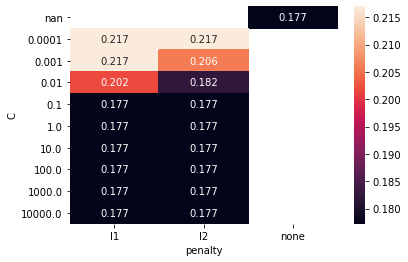

In [11]:
results = pd.DataFrame( best_model.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results['score_acc'] = 1 - best_model.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results

In [218]:
#assigning result
acc_1 = ("c = 0.1, penalty = l2, solver = saga, acc = 0.1772")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.217000
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.217000
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.217000
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.205542
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.200946
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.177154
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.169978
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.169223
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.168678
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.168211


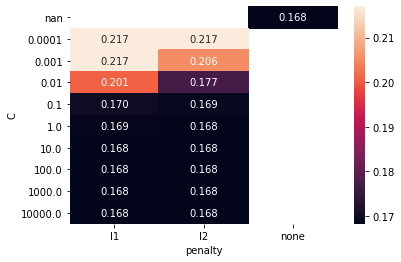

In [13]:
results = pd.DataFrame( best_model.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results['score_precision'] = 1 - best_model.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results

In [219]:
#assigning result
precision_1 = ("C = 1.0, penality = l2, solver = saga, precision = 0.168211")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2170
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2170
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2170
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2060
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2018
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1824
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1774
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1772
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1774
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1772


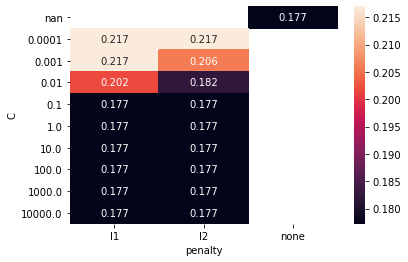

In [15]:
results = pd.DataFrame( best_model.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results['score_f1_micro'] = 1 - best_model.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results

In [220]:
#assigning result
f1micro_1 = ("c = 0.1, penalty = l2, solver = saga, f1_micro = 0.1772")

#### Trial 2

In [17]:
#Defining X and Y
X_credit_card = credit_card_df.iloc[:,0:-1]
Y_credit_card = credit_card_df.loc[:, "default payment next month"]
X_train, X_test, Y_train, Y_test = train_test_split( X_credit_card, Y_credit_card, train_size=5000, shuffle=True, random_state = 2)

In [18]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision','f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model2 = clf.fit(X_train, Y_train)

Wall time: 27 s


In [19]:
best_model2.cv_results_

{'mean_fit_time': array([0.00718656, 0.02563252, 0.01276593, 0.02024717, 0.0291223 ,
        0.03720174, 0.11499715, 0.15568762, 0.41306152, 0.34682379,
        0.51882811, 0.34707222, 0.53180232, 0.35962605, 0.56306686,
        0.3444849 , 0.51715999, 0.32431488, 0.01017294, 0.01934819,
        0.01376357, 0.02273912, 0.02413516, 0.02732682, 0.03191466,
        0.0337676 , 0.03676538, 0.02757144, 0.32105374]),
 'std_fit_time': array([0.00075223, 0.00636644, 0.00525457, 0.00159411, 0.00622528,
        0.00146567, 0.05070744, 0.02507812, 0.07283294, 0.06007011,
        0.0896823 , 0.06175438, 0.06921948, 0.05998875, 0.12238569,
        0.03781234, 0.07261059, 0.05366068, 0.0015959 , 0.01100871,
        0.00212975, 0.00547725, 0.00203389, 0.00184999, 0.00516297,
        0.00686187, 0.00815331, 0.00241459, 0.05134898]),
 'mean_score_time': array([0.00518022, 0.00598412, 0.00638294, 0.01615672, 0.00389075,
        0.00339108, 0.00598416, 0.00618348, 0.00539761, 0.00418887,
        0.004587

In [20]:
best_model2.cv_results_['rank_test_accuracy']

array([26, 26, 26, 24, 23, 21, 20, 18,  1,  2,  4,  5,  5,  5,  5,  5,  5,
        5, 26, 24, 21, 18,  2,  5,  5,  5,  5,  5,  5])

In [21]:
best_model2.cv_results_['params'][ np.argmin(best_model2.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [22]:
best_model2.cv_results_['params'][ np.argmin(best_model2.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [23]:
best_model2.cv_results_['params'][ np.argmin(best_model2.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2174
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2174
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2174
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2116
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2108
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1962
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1930
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1926
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1918
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1920


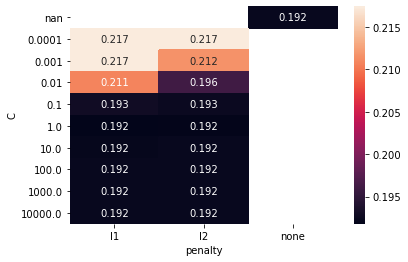

In [24]:
results2 = pd.DataFrame( best_model2.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results2['score_acc'] = 1 - best_model2.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols2 = results2.columns.to_series().str.split('__').apply(lambda x: x[-1])
results2.columns = cols2

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results2.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results2

In [221]:
#assigning result
acc_2 = ("c = 1.0, penalty = l1, solver = saga, acc = 0.1918")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.217400
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.217400
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.217400
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.210737
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.209627
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.189798
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.185304
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.183875
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.183173
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.183347


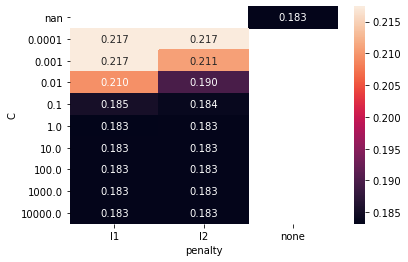

In [26]:
results2 = pd.DataFrame( best_model2.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results2['score_precision'] = 1 - best_model2.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols2 = results2.columns.to_series().str.split('__').apply(lambda x: x[-1])
results2.columns = cols2

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results2.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results2

In [223]:
#assigning result
precision_2 = ("C = 1.0, penality = l1, solver = saga, precision = 0.183173")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2174
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2174
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2174
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2116
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2108
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1962
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1930
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1926
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1918
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1920


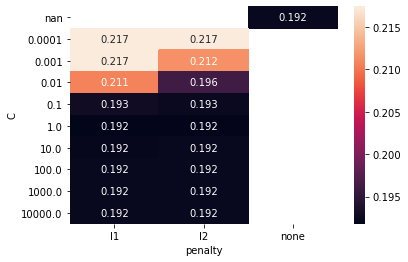

In [28]:
results2 = pd.DataFrame( best_model2.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results2['score_f1_micro'] = 1 - best_model2.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols2 = results2.columns.to_series().str.split('__').apply(lambda x: x[-1])
results2.columns = cols2

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results2.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results2

In [222]:
#assigning result
f1micro_2 = ("c = 1.0, penalty = l1, solver = saga, f1_micro = 0.1918")

#### Trial 3

In [30]:
#Defining X and Y
X_credit_card = credit_card_df.iloc[:,0:-1]
Y_credit_card = credit_card_df.loc[:, "default payment next month"]
X_train, X_test, Y_train, Y_test = train_test_split( X_credit_card, Y_credit_card, train_size=5000, shuffle=True, random_state = 3)

In [31]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision', 'f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model3 = clf.fit(X_train, Y_train)

Wall time: 1min 23s


In [32]:
best_model3.cv_results_

{'mean_fit_time': array([0.00777917, 0.0428853 , 0.01276517, 0.05826616, 0.12794209,
        0.13342323, 0.75810246, 0.73646016, 1.73021421, 1.09606047,
        1.4470314 , 1.05852222, 1.56072211, 1.07903843, 1.62017884,
        1.11867652, 1.63581591, 1.05865159, 0.00917497, 0.00907712,
        0.01426358, 0.02144389, 0.02493324, 0.02662997, 0.029423  ,
        0.03640423, 0.02942266, 0.03456907, 1.08915353]),
 'std_fit_time': array([7.46174516e-04, 1.21168611e-02, 7.46098159e-04, 1.95078189e-02,
        5.17604285e-02, 4.33071080e-02, 3.28166074e-01, 2.86756307e-01,
        6.26658221e-01, 3.82405631e-01, 5.13441814e-01, 3.79883360e-01,
        5.58645624e-01, 3.79205012e-01, 5.63635460e-01, 3.81183246e-01,
        5.65172554e-01, 3.75107502e-01, 7.46442152e-04, 2.02274491e-04,
        7.46887827e-04, 1.48073828e-03, 1.26142668e-03, 1.32456372e-03,
        2.71306963e-03, 7.23243816e-03, 2.23150392e-03, 2.62898235e-03,
        3.86158169e-01]),
 'mean_score_time': array([0.00378995, 

In [33]:
best_model3.cv_results_['rank_test_accuracy']

array([26, 26, 26, 24, 23, 21, 20, 18, 14, 16,  5, 14,  5,  5,  5,  5,  5,
        5, 26, 24, 21, 18, 16,  5,  1,  1,  1,  1,  5])

In [34]:
best_model3.cv_results_['params'][ np.argmin(best_model3.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 100.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'lbfgs'}

In [35]:
best_model3.cv_results_['params'][ np.argmin(best_model3.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 100.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'lbfgs'}

In [36]:
best_model3.cv_results_['params'][ np.argmin(best_model3.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 100.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'lbfgs'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2234
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2234
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2234
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2188
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2162
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1958
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1922
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1894
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1882
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1884


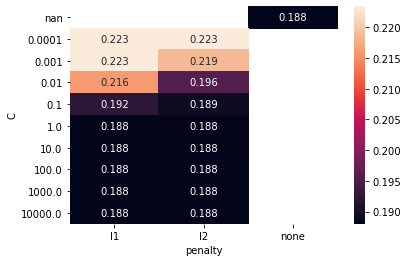

In [37]:
results3 = pd.DataFrame( best_model3.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results3['score_acc'] = 1 - best_model3.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols3 = results3.columns.to_series().str.split('__').apply(lambda x: x[-1])
results3.columns = cols3

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results3.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results3

In [224]:
#assigning result
acc_3 = ("c = 100, penalty = l2, solver = lbfgs, acc = 0.1878")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.223400
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.223400
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.223400
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.216964
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.214309
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.190894
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.185633
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.182490
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.181013
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.180907


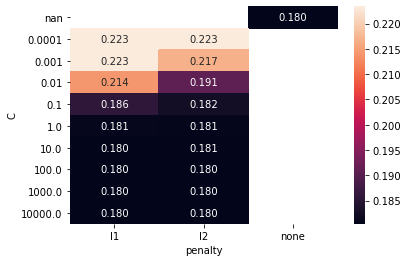

In [39]:
results3 = pd.DataFrame( best_model3.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results3['score_precision'] = 1 - best_model3.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols3 = results3.columns.to_series().str.split('__').apply(lambda x: x[-1])
results3.columns = cols3

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results3.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results3

In [40]:
#assigning result
precision_3 = ("c = 100, penalty = l2, solver = lbfgs, precision = 0.180230")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2234
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2234
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2234
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2188
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2162
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1958
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1922
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1894
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1882
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1884


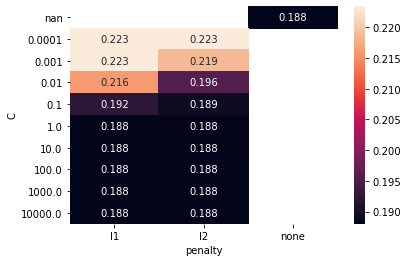

In [41]:
results3 = pd.DataFrame( best_model3.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results3['score_f1_micro'] = 1 - best_model3.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols3 = results3.columns.to_series().str.split('__').apply(lambda x: x[-1])
results3.columns = cols3

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results3.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results3

In [225]:
#assigning result
f1micro_3 = ("c = 100, penalty = l2, solver = lbfgs, f1_micro = 0.1878")

#### Trial 4

In [43]:
#Defining X and Y
X_credit_card = credit_card_df.iloc[:,0:-1]
Y_credit_card = credit_card_df.loc[:, "default payment next month"]
X_train, X_test, Y_train, Y_test = train_test_split( X_credit_card, Y_credit_card, train_size=5000, shuffle=True, random_state = 4)

In [44]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision', 'f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model4 = clf.fit(X_train, Y_train)

Wall time: 1min 32s


In [45]:
best_model4.cv_results_

{'mean_fit_time': array([0.00918088, 0.04547796, 0.01356359, 0.05494533, 0.11539531,
        0.14681334, 0.30848646, 0.60348039, 1.47503495, 1.10613046,
        1.72568927, 1.26762438, 1.75512595, 1.28059134, 1.80565915,
        1.38020492, 2.09282365, 1.44586496, 0.03770199, 0.02692742,
        0.02732668, 0.02433515, 0.03211427, 0.04930143, 0.03607545,
        0.02628436, 0.02578163, 0.03987923, 1.41480131]),
 'std_fit_time': array([0.0014611 , 0.01026077, 0.00232634, 0.0143204 , 0.02969648,
        0.02069462, 0.09536689, 0.17897063, 0.48532916, 0.31047945,
        0.54878262, 0.3804928 , 0.54649278, 0.35001577, 0.51090476,
        0.4050342 , 0.53784777, 0.36847751, 0.01899888, 0.00743667,
        0.01206047, 0.00586996, 0.01000087, 0.01875792, 0.0059207 ,
        0.00116593, 0.0016022 , 0.00682601, 0.43296787]),
 'mean_score_time': array([0.00358472, 0.00359044, 0.00339117, 0.00359082, 0.00359049,
        0.00757971, 0.00478749, 0.00359101, 0.00536776, 0.00336924,
        0.003584

In [46]:
best_model4.cv_results_['rank_test_accuracy']

array([26, 26, 26, 24, 23, 21,  5,  5,  5,  1,  1,  5,  9,  9,  9,  9,  9,
        9, 26, 24, 21,  1,  1,  9,  9,  9,  9,  9,  9])

In [47]:
best_model4.cv_results_['params'][ np.argmin(best_model4.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [48]:
best_model4.cv_results_['params'][ np.argmin(best_model4.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [49]:
best_model4.cv_results_['params'][ np.argmin(best_model4.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2228
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2228
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2228
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2120
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2072
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1912
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1886
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1886
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1886
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1884


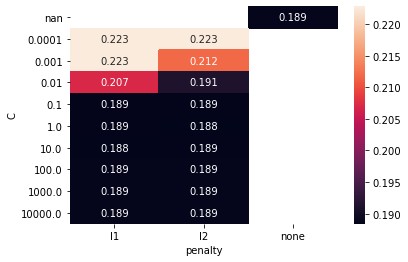

In [50]:
results4 = pd.DataFrame( best_model4.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results4['score_acc'] = 1 - best_model4.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols4 = results4.columns.to_series().str.split('__').apply(lambda x: x[-1])
results4.columns = cols4

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results4.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results4

In [227]:
#assigning result
acc_4 = ("c = 1.0, penalty = l2, solver = saga, acc = 0.1884")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.222800
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.222800
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.222800
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.210909
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.204195
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.185080
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.179474
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.177790
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.177502
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.176898


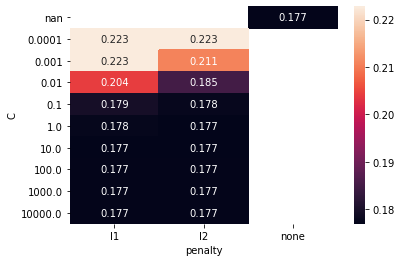

In [52]:
results4 = pd.DataFrame( best_model4.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results4['score_precision'] = 1 - best_model4.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols4 = results4.columns.to_series().str.split('__').apply(lambda x: x[-1])
results4.columns = cols4

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results4.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results4

In [226]:
#assigning result
precision_4 = ("c = 1.0, penalty = l2, solver = saga, precision = 0.176898")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2228
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2228
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2228
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2120
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2072
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1912
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1886
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1886
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1886
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1884


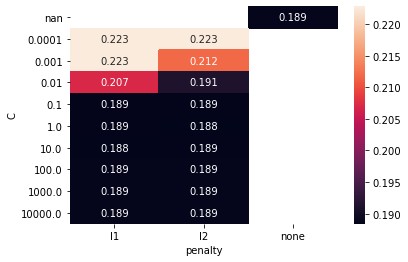

In [54]:
results4 = pd.DataFrame( best_model4.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results4['score_f1_micro'] = 1 - best_model4.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols4 = results4.columns.to_series().str.split('__').apply(lambda x: x[-1])
results4.columns = cols4

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results4.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results4

In [228]:
#assigning result
f1micro_4 = ("c = 1.0, penalty = l2, solver = saga, f1_micro = 0.1884")

#### Trial 5

In [56]:
#Defining X and Y
X_credit_card = credit_card_df.iloc[:,0:-1]
Y_credit_card = credit_card_df.loc[:, "default payment next month"]
X_train, X_test, Y_train, Y_test = train_test_split( X_credit_card, Y_credit_card, train_size=5000, shuffle=True, random_state = 5)

In [57]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision', 'f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model5 = clf.fit(X_train, Y_train)

Wall time: 47.8 s


In [58]:
best_model5.cv_results_

{'mean_fit_time': array([0.02134275, 0.03390927, 0.01136932, 0.03490691, 0.0801857 ,
        0.07539825, 0.14198408, 0.32537203, 0.83487039, 0.60615745,
        0.89463358, 0.65900378, 0.91532488, 0.66990504, 0.97312579,
        0.67364783, 0.94952931, 0.65416884, 0.00917482, 0.00937462,
        0.01206956, 0.01855078, 0.02373681, 0.02692809, 0.02473373,
        0.02413545, 0.02632952, 0.02632961, 0.67134728]),
 'std_fit_time': array([0.02675071, 0.00643221, 0.00241009, 0.00759559, 0.02703937,
        0.0194476 , 0.0577015 , 0.10641435, 0.31126602, 0.21648484,
        0.32903087, 0.22729836, 0.29241332, 0.22428244, 0.356086  ,
        0.22840977, 0.29744821, 0.21338292, 0.00039924, 0.00101698,
        0.00149452, 0.00135269, 0.00116321, 0.00578129, 0.00097747,
        0.00097712, 0.00240963, 0.00101708, 0.21747976]),
 'mean_score_time': array([0.00478721, 0.00339122, 0.00398912, 0.00319138, 0.00359049,
        0.00478745, 0.00359049, 0.00398951, 0.00437589, 0.00318112,
        0.003580

In [59]:
best_model5.cv_results_['rank_test_accuracy']

array([26, 26, 26, 24, 23, 18, 22, 20, 17, 15, 15,  1,  1,  1,  1,  1,  1,
        1, 26, 24, 18, 20,  1,  1,  1,  1,  1,  1,  1])

In [60]:
best_model5.cv_results_['params'][ np.argmin(best_model5.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [61]:
best_model5.cv_results_['params'][ np.argmin(best_model5.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [62]:
best_model5.cv_results_['params'][ np.argmin(best_model5.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2054
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2054
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2054
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.1980
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.1952
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1796
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1808
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1798
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1790
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1788


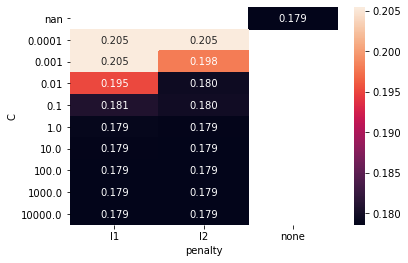

In [63]:
results5 = pd.DataFrame( best_model5.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results5['score_acc'] = 1 - best_model5.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols5 = results5.columns.to_series().str.split('__').apply(lambda x: x[-1])
results5.columns = cols5

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results5.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results5

In [230]:
#assigning result
acc_5 = ("c = 10, penalty = l2, solver = saga, acc = 0.1786")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.205400
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.205400
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.205400
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.198379
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.193833
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.175139
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.173832
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.171985
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.171280
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.171102


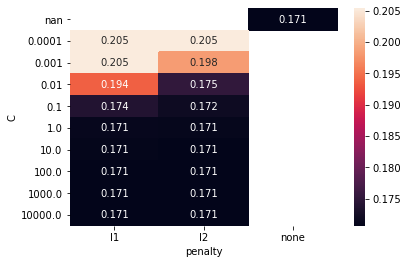

In [65]:
results5 = pd.DataFrame( best_model5.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results5['score_precision'] = 1 - best_model5.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols5 = results5.columns.to_series().str.split('__').apply(lambda x: x[-1])
results5.columns = cols5

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results5.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results5

In [229]:
#assigning result
precision_5 = ("c = 10, penalty = l2, solver = saga, precision = 0.170645")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2054
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2054
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2054
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.1980
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.1952
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1796
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1808
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1798
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1790
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1788


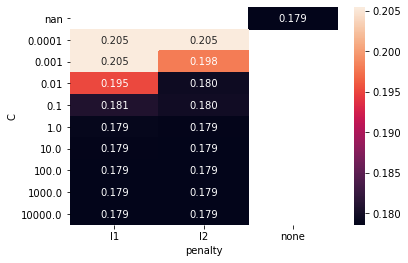

In [67]:
results5 = pd.DataFrame( best_model5.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results5['score_f1_micro'] = 1 - best_model5.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols5 = results5.columns.to_series().str.split('__').apply(lambda x: x[-1])
results5.columns = cols5

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results5.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results5

In [231]:
#assigning result
f1micro_5 = ("c = 10, penalty = l2, solver = saga, f1_micro = 0.1786")

#### Trial 6

In [69]:
#Defining X and Y
X_credit_card = credit_card_df.iloc[:,0:-1]
Y_credit_card = credit_card_df.loc[:, "default payment next month"]
X_train, X_test, Y_train, Y_test = train_test_split( X_credit_card, Y_credit_card, train_size=5000, shuffle=True, random_state = 6)

In [70]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision', 'f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model6 = clf.fit(X_train, Y_train)

Wall time: 1min 28s


In [71]:
best_model6.cv_results_

{'mean_fit_time': array([0.00827942, 0.04139066, 0.01057167, 0.0510632 , 0.12772222,
        0.1093544 , 0.1935492 , 0.54977102, 1.49779372, 1.10617104,
        1.7079545 , 1.22991776, 1.77287588, 1.25561619, 1.86578302,
        1.21949778, 1.95878172, 1.25181298, 0.01276593, 0.01256623,
        0.01496029, 0.03410869, 0.05425491, 0.06023846, 0.02533236,
        0.03031907, 0.04288578, 0.02732673, 1.24769444]),
 'std_fit_time': array([0.0012469 , 0.00512482, 0.00162028, 0.00908394, 0.01732026,
        0.01885724, 0.06479569, 0.08135049, 0.33875427, 0.25309771,
        0.41283913, 0.28669734, 0.40351928, 0.34211224, 0.52358843,
        0.26257532, 0.4532218 , 0.32747415, 0.00222146, 0.00205373,
        0.00178411, 0.01429245, 0.02652661, 0.05229931, 0.0025701 ,
        0.00119687, 0.01404786, 0.00606984, 0.26771051]),
 'mean_score_time': array([0.00458751, 0.00359082, 0.00319161, 0.00718074, 0.00878396,
        0.00339317, 0.00339007, 0.00317831, 0.00358534, 0.00377951,
        0.004175

In [72]:
best_model6.cv_results_['rank_test_accuracy']

array([26, 26, 26, 24, 23, 21, 20, 16, 19, 16, 10, 10,  1,  1,  1,  1,  1,
        1, 26, 24, 21, 16, 15,  1,  1, 10, 10, 10,  1])

In [73]:
best_model6.cv_results_['params'][ np.argmin(best_model6.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 100.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [74]:
best_model6.cv_results_['params'][ np.argmin(best_model6.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 100.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [75]:
best_model6.cv_results_['params'][ np.argmin(best_model6.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 100.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2194
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2194
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2194
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2136
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2118
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1980
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1938
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1924
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1928
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1924


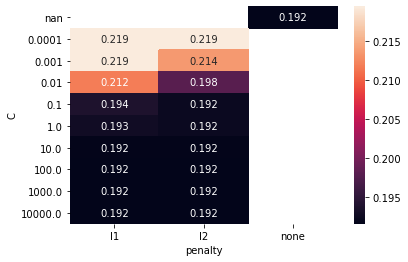

In [76]:
results6 = pd.DataFrame( best_model6.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results6['score_acc'] = 1 - best_model6.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols6 = results6.columns.to_series().str.split('__').apply(lambda x: x[-1])
results6.columns = cols6

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results6.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results6

In [232]:
#assigning result
acc_6 = ("c = 100, penalty = l1, solver = saga, acc = 0.1916")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.219400
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.219400
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.219400
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.212761
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.210386
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.191992
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.186931
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.185456
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.185132
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.184918


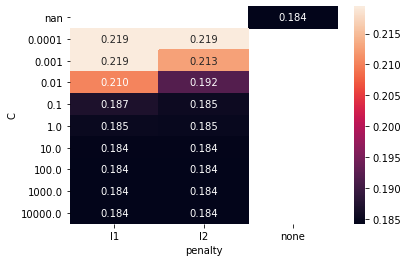

In [78]:
results6 = pd.DataFrame( best_model6.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results6['score_precision'] = 1 - best_model6.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols6 = results6.columns.to_series().str.split('__').apply(lambda x: x[-1])
results6.columns = cols6

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results6.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results6

In [234]:
#assigning result
precision_6 = ("c = 100, penalty = l1, solver = saga, precision = 0.184219")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2194
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2194
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2194
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2136
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2118
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1980
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1938
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1924
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1928
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1924


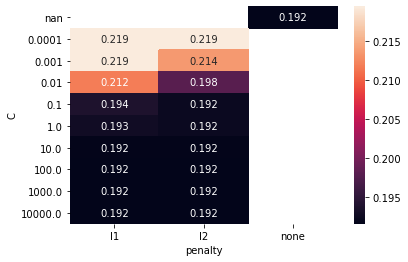

In [80]:
results6 = pd.DataFrame( best_model6.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results6['score_f1_micro'] = 1 - best_model6.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols6 = results6.columns.to_series().str.split('__').apply(lambda x: x[-1])
results6.columns = cols6

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results6.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results6

In [233]:
#assigning result
f1micro_6 = ("c = 100, penalty = l1, solver = saga, f1_micro = 0.1916")

#### Trial 7

In [82]:
#Defining X and Y
X_credit_card = credit_card_df.iloc[:,0:-1]
Y_credit_card = credit_card_df.loc[:, "default payment next month"]
X_train, X_test, Y_train, Y_test = train_test_split( X_credit_card, Y_credit_card, train_size=5000, shuffle=True, random_state = 7)

In [83]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision','f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model7 = clf.fit(X_train, Y_train)

Wall time: 1min 20s


In [84]:
best_model7.cv_results_

{'mean_fit_time': array([0.00718088, 0.03740139, 0.01216726, 0.04308467, 0.15361018,
        0.10592146, 0.26686854, 0.47441425, 1.28820314, 0.98983383,
        1.52046351, 1.20012336, 1.70988269, 1.07824607, 1.67358599,
        1.12955694, 1.71976371, 1.15113301, 0.01176825, 0.01466227,
        0.01715422, 0.02752643, 0.04328423, 0.04647598, 0.0682476 ,
        0.04235725, 0.07295732, 0.03077765, 1.06228828]),
 'std_fit_time': array([0.00116296, 0.00454834, 0.00395919, 0.00770984, 0.05486722,
        0.0207094 , 0.0501398 , 0.07806346, 0.19284543, 0.14527519,
        0.24996695, 0.22152798, 0.26679556, 0.19299156, 0.27644641,
        0.18252958, 0.25176309, 0.17916243, 0.00146577, 0.00270778,
        0.00469498, 0.00319145, 0.00522424, 0.00866193, 0.03194897,
        0.02102871, 0.04291407, 0.00336778, 0.14901791]),
 'mean_score_time': array([0.00319147, 0.00598435, 0.00678186, 0.00339112, 0.00379558,
        0.00530725, 0.00338664, 0.00578437, 0.00419321, 0.00677638,
        0.004183

In [85]:
best_model7.cv_results_['rank_test_accuracy']

array([26, 26, 26, 24, 23, 21, 19,  1, 20, 10,  1,  1,  1, 10, 10,  1,  1,
        1, 26, 24, 21,  1,  1, 10, 10, 10, 10, 10, 10])

In [86]:
best_model7.cv_results_['params'][ np.argmin(best_model7.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [87]:
best_model7.cv_results_['params'][ np.argmin(best_model7.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [88]:
best_model7.cv_results_['params'][ np.argmin(best_model7.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2214
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2214
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2214
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2152
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2150
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2018
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1982
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1978
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1984
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1980


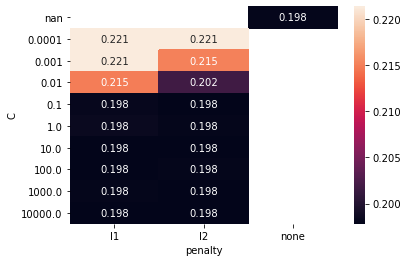

In [89]:
results7 = pd.DataFrame( best_model7.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results7['score_acc'] = 1 - best_model7.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols7 = results7.columns.to_series().str.split('__').apply(lambda x: x[-1])
results7.columns = cols7

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results7.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results7

In [236]:
#assigning result
acc_7 = ("c = 0.1, penalty = l2, solver = saga, acc = 0.1978")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.221400
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.221400
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.221400
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.214458
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.212905
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.194345
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.190485
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.189213
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.189063
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.188314


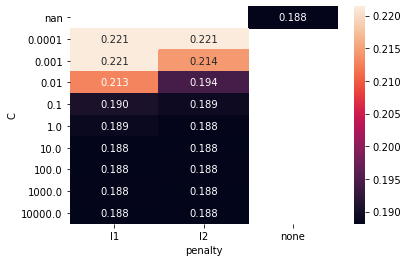

In [91]:
results7 = pd.DataFrame( best_model7.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results7['score_precision'] = 1 - best_model7.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols7 = results7.columns.to_series().str.split('__').apply(lambda x: x[-1])
results7.columns = cols7

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results7.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results7

In [237]:
#assigning result
precision_7 = ("C = 10, penality = l1, solver = saga, precision = 0.188138")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2214
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2214
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2214
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2152
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2150
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2018
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1982
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1978
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1984
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1980


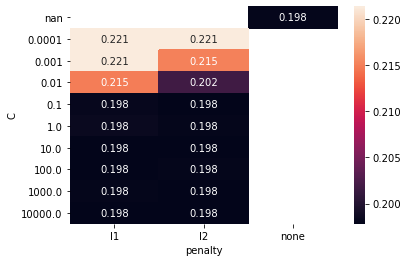

In [93]:
results7 = pd.DataFrame( best_model7.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results7['score_f1_micro'] = 1 - best_model7.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols7 = results7.columns.to_series().str.split('__').apply(lambda x: x[-1])
results7.columns = cols7

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results7.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results7

In [235]:
#assigning result
f1micro_7 = ("c = 0.1, penalty = l2, solver = saga, f1_micro = 0.1978")

#### Trial 8

In [95]:
#Defining X and Y
X_credit_card = credit_card_df.iloc[:,0:-1]
Y_credit_card = credit_card_df.loc[:, "default payment next month"]
X_train, X_test, Y_train, Y_test = train_test_split( X_credit_card, Y_credit_card, train_size=5000, shuffle=True, random_state = 8)

In [96]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision','f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model8 = clf.fit(X_train, Y_train)

Wall time: 1min 20s


In [97]:
best_model8.cv_results_

{'mean_fit_time': array([0.006884  , 0.03740125, 0.01136994, 0.03749948, 0.08796487,
        0.10310197, 0.50601454, 0.4680058 , 1.37947121, 0.96729527,
        1.53369217, 1.12462263, 1.58882885, 1.12712903, 1.68025017,
        1.17114916, 1.64779987, 1.14163489, 0.00937505, 0.0147604 ,
        0.01695485, 0.03710103, 0.03740134, 0.03799977, 0.03640394,
        0.03121777, 0.04637756, 0.0292232 , 1.10409198]),
 'std_fit_time': array([0.00110963, 0.01309483, 0.00101721, 0.00884379, 0.03028619,
        0.02918138, 0.21093408, 0.16451109, 0.46993325, 0.31672995,
        0.50671124, 0.36882692, 0.438478  , 0.36265392, 0.56692209,
        0.38989212, 0.53509364, 0.36631674, 0.0018498 , 0.00291801,
        0.00327751, 0.01316133, 0.00496881, 0.00430518, 0.00330703,
        0.00330223, 0.03342164, 0.00116324, 0.35201536]),
 'mean_score_time': array([0.00338945, 0.01156921, 0.00538549, 0.00379014, 0.00359015,
        0.00439839, 0.00357308, 0.00398254, 0.00498219, 0.00337906,
        0.004178

In [98]:
best_model8.cv_results_['rank_test_accuracy']

array([26, 26, 26, 24, 23, 21, 20,  1, 19,  4, 18,  4,  4,  4,  4,  4,  4,
        4, 26, 24, 21,  1,  1,  4,  4,  4,  4,  4,  4])

In [99]:
best_model8.cv_results_['params'][ np.argmin(best_model8.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [100]:
best_model8.cv_results_['params'][ np.argmin(best_model8.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'lbfgs'}

In [101]:
best_model8.cv_results_['params'][ np.argmin(best_model8.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2266
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2266
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2266
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2198
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2178
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1974
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1946
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1930
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1936
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1932


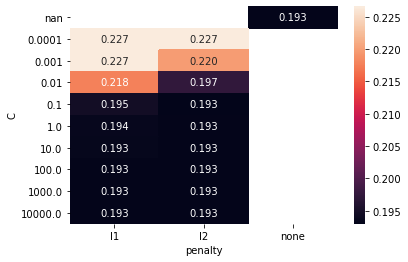

In [102]:
results8 = pd.DataFrame( best_model8.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results8['score_acc'] = 1 - best_model8.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols8 = results8.columns.to_series().str.split('__').apply(lambda x: x[-1])
results8.columns = cols8

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results8.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results8

In [239]:
#assigning result
acc_8 = ("c = 0.1, penalty = l2, solver = saga, acc = 0.1930")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.226600
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.226600
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.226600
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.217884
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.216255
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.192160
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.188261
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.186042
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.185885
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.185401


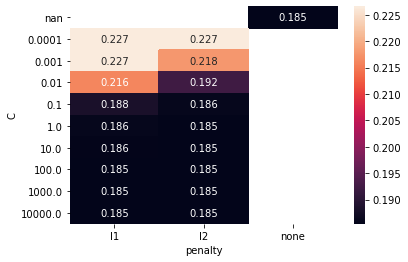

In [104]:
results8 = pd.DataFrame( best_model8.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results8['score_precision'] = 1 - best_model8.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols8 = results8.columns.to_series().str.split('__').apply(lambda x: x[-1])
results8.columns = cols8

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results8.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results8

In [240]:
#assigning result
precision_8 = ("c = 1.0, penalty = l2, solver = lbfgs, precision = 0.185221")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2266
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2266
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2266
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2198
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2178
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1974
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1946
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1930
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1936
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1932


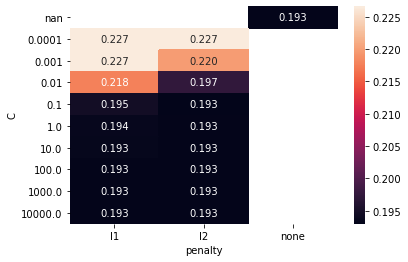

In [106]:
results8 = pd.DataFrame( best_model8.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results8['score_f1_micro'] = 1 - best_model8.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols8 = results8.columns.to_series().str.split('__').apply(lambda x: x[-1])
results8.columns = cols8

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results8.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results8

In [238]:
#assigning result
f1micro_8 = ("c = 0.1, penalty = l2, solver = saga, f1_micro = 0.1930")

#### Trial 9

In [108]:
#Defining X and Y
X_credit_card = credit_card_df.iloc[:,0:-1]
Y_credit_card = credit_card_df.loc[:, "default payment next month"]
X_train, X_test, Y_train, Y_test = train_test_split( X_credit_card, Y_credit_card, train_size=5000, shuffle=True, random_state = 9)

In [109]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision','f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model9 = clf.fit(X_train, Y_train)

Wall time: 17.3 s


In [110]:
best_model9.cv_results_

{'mean_fit_time': array([0.00708208, 0.01914878, 0.00917563, 0.01914892, 0.03091717,
        0.02752647, 0.07440081, 0.0903985 , 0.21343012, 0.18392091,
        0.29422836, 0.21496344, 0.30965047, 0.20715327, 0.30912995,
        0.21596484, 0.33951159, 0.2154264 , 0.00917559, 0.00977407,
        0.01276588, 0.01835103, 0.03314896, 0.02998142, 0.03358645,
        0.04056907, 0.10854282, 0.02837572, 0.21743207]),
 'std_fit_time': array([0.00079705, 0.00097719, 0.00171583, 0.00074588, 0.01551481,
        0.00162061, 0.03301536, 0.00539613, 0.06301566, 0.02056271,
        0.03797174, 0.03032466, 0.05180995, 0.0283905 , 0.03989348,
        0.02537028, 0.0502604 , 0.03289981, 0.00074634, 0.00074631,
        0.00074648, 0.00205353, 0.00660395, 0.00522341, 0.00844275,
        0.02687326, 0.08386654, 0.00186534, 0.02878085]),
 'mean_score_time': array([0.00319142, 0.00339103, 0.0037899 , 0.00299182, 0.00359039,
        0.00319166, 0.00378995, 0.00399203, 0.00379286, 0.00319614,
        0.003784

In [111]:
best_model9.cv_results_['rank_test_accuracy']

array([26, 26, 26, 24, 23, 21, 20,  3,  2,  3,  1, 18,  7,  7,  7,  7,  7,
        7, 26, 24, 21,  3,  3, 18,  7,  7,  7,  7,  7])

In [112]:
best_model9.cv_results_['params'][ np.argmin(best_model9.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [113]:
best_model9.cv_results_['params'][ np.argmin(best_model9.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [114]:
best_model9.cv_results_['params'][ np.argmin(best_model9.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2226
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2226
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2226
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2140
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2114
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1922
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1886
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1874
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1870
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1874


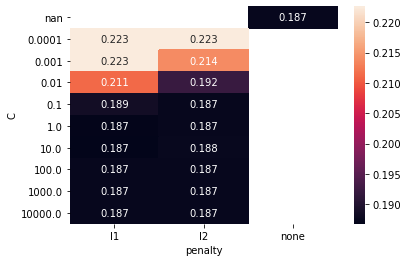

In [115]:
results9 = pd.DataFrame( best_model9.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results9['score_acc'] = 1 - best_model9.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols9 = results9.columns.to_series().str.split('__').apply(lambda x: x[-1])
results9.columns = cols9

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results9.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results9

In [242]:
#assigning result
acc_9 = ("c = 10.0, penalty = l1, solver = saga, acc = 0.1868")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.222600
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.222600
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.222600
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.213888
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.208523
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.185627
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.179572
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.177093
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.176444
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.176377


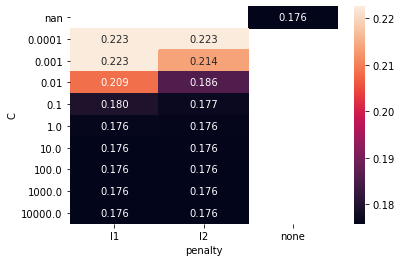

In [117]:
results9 = pd.DataFrame( best_model9.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results9['score_precision'] = 1 - best_model9.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols9 = results9.columns.to_series().str.split('__').apply(lambda x: x[-1])
results9.columns = cols9

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results9.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results9

In [241]:
#assigning result
precision_9 = ("c = 10.0, penalty = l1, solver = saga, precision = 0.175835")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2226
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2226
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2226
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2140
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2114
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1922
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1886
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1874
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1870
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1874


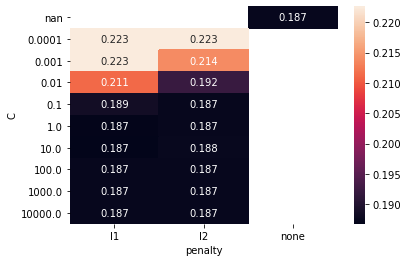

In [119]:
results9 = pd.DataFrame( best_model9.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results9['score_f1_micro'] = 1 - best_model9.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols9 = results9.columns.to_series().str.split('__').apply(lambda x: x[-1])
results9.columns = cols9

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results9.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results9

In [243]:
#assigning result
f1micro_9 = ("c = 10.0, penalty = l1, solver = saga, f1_micro = 0.1868")

#### Trial 10

In [121]:
#Defining X and Y
X_credit_card = credit_card_df.iloc[:,0:-1]
Y_credit_card = credit_card_df.loc[:, "default payment next month"]
X_train, X_test, Y_train, Y_test = train_test_split( X_credit_card, Y_credit_card, train_size=5000, shuffle=True, random_state = 10)

In [122]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision','f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model10 = clf.fit(X_train, Y_train)

Wall time: 1min 15s


In [123]:
best_model10.cv_results_

{'mean_fit_time': array([0.00957441, 0.04029255, 0.00917578, 0.04807134, 0.12227283,
        0.11050429, 0.39195786, 0.50613122, 1.13297329, 0.9682735 ,
        1.39919214, 1.03093076, 1.47916474, 1.08056707, 1.66049747,
        1.06999121, 1.54743981, 1.02889657, 0.01256628, 0.0139626 ,
        0.01934824, 0.02353721, 0.03410907, 0.02792559, 0.02493339,
        0.02453451, 0.02377467, 0.02437887, 1.00922208]),
 'std_fit_time': array([0.00184935, 0.00439698, 0.00255458, 0.00825821, 0.01397082,
        0.02301595, 0.12615859, 0.08222575, 0.30469074, 0.21371848,
        0.26602353, 0.20140124, 0.25054444, 0.15937458, 0.36033427,
        0.20593022, 0.29088883, 0.16275981, 0.00205395, 0.00141064,
        0.00411699, 0.00205373, 0.01151759, 0.00327767, 0.00209212,
        0.00272047, 0.00255658, 0.00249902, 0.2114106 ]),
 'mean_score_time': array([0.00438814, 0.00319128, 0.00299187, 0.0037899 , 0.00638332,
        0.00418882, 0.00418916, 0.00318546, 0.00418868, 0.00398479,
        0.003585

In [124]:
best_model10.cv_results_['rank_test_accuracy']

array([26, 26, 26, 24, 23, 21,  3,  1,  4,  5, 19,  5,  5,  5,  5,  5,  5,
        5, 26, 25, 21,  1,  5, 19,  5,  5,  5,  5,  5])

In [125]:
best_model10.cv_results_['params'][ np.argmin(best_model10.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [126]:
best_model10.cv_results_['params'][ np.argmin(best_model10.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [127]:
best_model10.cv_results_['params'][ np.argmin(best_model10.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2202
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2202
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2202
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2136
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2112
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1944
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1886
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1882
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1894
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1902


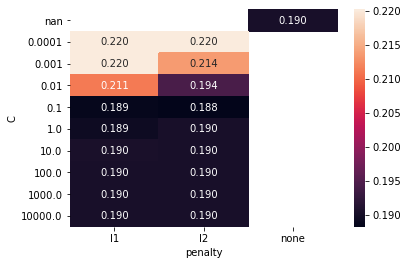

In [128]:
results10 = pd.DataFrame( best_model10.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results10['score_acc'] = 1 - best_model10.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols10 = results10.columns.to_series().str.split('__').apply(lambda x: x[-1])
results10.columns = cols10

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results10.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results10

In [244]:
#assigning result
acc_10 = ("c = 0.1, penalty = l2, solver = saga, acc = 0.1882")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.220200
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.220200
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.220200
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.212818
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.210426
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.188803
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.181736
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.180833
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.180648
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.180808


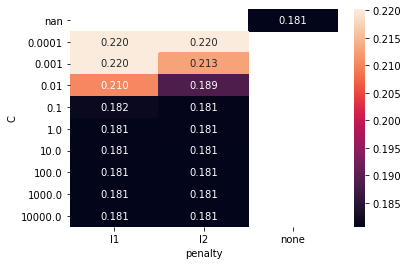

In [130]:
results10 = pd.DataFrame( best_model10.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results10['score_precision'] = 1 - best_model10.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols10 = results10.columns.to_series().str.split('__').apply(lambda x: x[-1])
results10.columns = cols10

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results10.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results10

In [246]:
#assigning result
precision_10 = ("c = 1.0, penalty = l1, solver = saga, precision = 0.180648")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2202
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2202
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2202
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2136
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2112
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1944
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1886
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1882
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1894
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1902


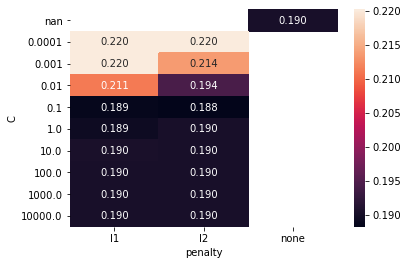

In [132]:
results10 = pd.DataFrame( best_model10.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results10['score_f1_micro'] = 1 - best_model10.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols10 = results10.columns.to_series().str.split('__').apply(lambda x: x[-1])
results10.columns = cols10

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results10.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results10

In [245]:
#assigning result
f1micro_10 = ("c = 0.1, penalty = l2, solver = saga, f1_micro = 0.1882")

#### Trial 11

In [134]:
#Defining X and Y
X_credit_card = credit_card_df.iloc[:,0:-1]
Y_credit_card = credit_card_df.loc[:, "default payment next month"]
X_train, X_test, Y_train, Y_test = train_test_split( X_credit_card, Y_credit_card, train_size=5000, shuffle=True, random_state = 11)

In [135]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision','f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model11 = clf.fit(X_train, Y_train)

Wall time: 53.6 s


In [136]:
best_model11.cv_results_

{'mean_fit_time': array([0.0073854 , 0.02273903, 0.00877638, 0.0227396 , 0.0435813 ,
        0.07014313, 0.12658176, 0.31100197, 0.97258043, 0.64581051,
        1.01001844, 0.77051153, 1.05798202, 0.78167515, 1.08634806,
        0.77191491, 1.09737396, 0.77058496, 0.01037259, 0.01127133,
        0.01515946, 0.01934843, 0.02573137, 0.03251295, 0.03031883,
        0.03670173, 0.02976804, 0.02626286, 0.76921964]),
 'std_fit_time': array([0.0004948 , 0.00159605, 0.00159555, 0.00171559, 0.00368096,
        0.02117641, 0.04562508, 0.06865334, 0.21730272, 0.13791545,
        0.21538011, 0.15348953, 0.22977871, 0.1764888 , 0.22567672,
        0.18052374, 0.23690919, 0.1737432 , 0.00079825, 0.00212859,
        0.00193385, 0.00101696, 0.00159559, 0.0043519 , 0.00184959,
        0.01536522, 0.0054296 , 0.0017078 , 0.1780554 ]),
 'mean_score_time': array([0.00298696, 0.0037899 , 0.00379014, 0.00398889, 0.00389528,
        0.0048007 , 0.00538545, 0.00378962, 0.00438828, 0.00318093,
        0.003772

In [137]:
best_model11.cv_results_['rank_test_accuracy']

array([26, 26, 26, 24, 23, 21, 18, 18, 15, 15,  9,  9,  1,  1,  1,  1,  1,
        1, 26, 24, 21, 18, 15,  1,  9,  9,  9,  9,  1])

In [138]:
best_model11.cv_results_['params'][ np.argmin(best_model11.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 100.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [139]:
best_model11.cv_results_['params'][ np.argmin(best_model11.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 100.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [140]:
best_model11.cv_results_['params'][ np.argmin(best_model11.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 100.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2178
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2178
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2178
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2156
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2112
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2002
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1954
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1954
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1942
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1942


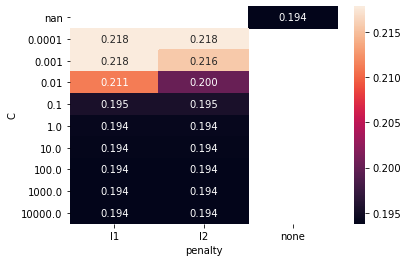

In [141]:
results11 = pd.DataFrame( best_model11.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results11['score_acc'] = 1 - best_model11.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols11 = results11.columns.to_series().str.split('__').apply(lambda x: x[-1])
results11.columns = cols11

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results11.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results11

In [248]:
#assigning result
acc_11 = ("c = 100, penalty = l1, solver = saga, acc = 0.1938")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.217800
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.217800
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.217800
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.213545
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.209670
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.193940
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.189049
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.187599
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.186156
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.186290


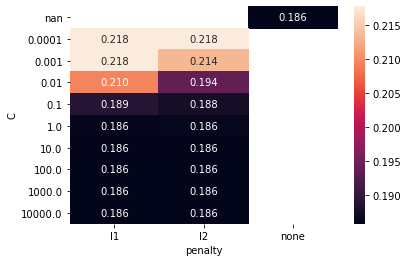

In [143]:
results11 = pd.DataFrame( best_model11.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results11['score_precision'] = 1 - best_model11.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols11 = results11.columns.to_series().str.split('__').apply(lambda x: x[-1])
results11.columns = cols11

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results11.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results11

In [247]:
#assigning result
precision_11 = ("c = 100, penalty = l1, solver = saga, precision = 0.185804")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2178
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2178
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2178
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2156
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2112
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2002
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1954
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1954
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1942
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1942


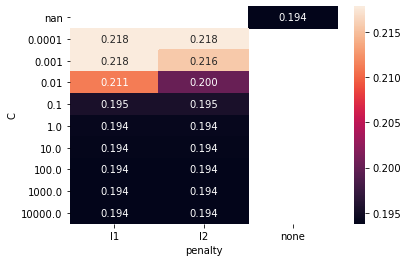

In [145]:
results11 = pd.DataFrame( best_model11.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results11['score_f1_micro'] = 1 - best_model11.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols11 = results11.columns.to_series().str.split('__').apply(lambda x: x[-1])
results11.columns = cols11

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results11.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results11

In [249]:
#assigning result
f1micro_11 = ("c = 100, penalty = l1, solver = saga, f1_micro = 0.1938")

#### Trial 12

In [147]:
#Defining X and Y
X_credit_card = credit_card_df.iloc[:,0:-1]
Y_credit_card = credit_card_df.loc[:, "default payment next month"]
X_train, X_test, Y_train, Y_test = train_test_split( X_credit_card, Y_credit_card, train_size=5000, shuffle=True, random_state = 12)

In [148]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision','f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model12 = clf.fit(X_train, Y_train)

Wall time: 40.2 s


In [149]:
best_model12.cv_results_

{'mean_fit_time': array([0.00758419, 0.02712736, 0.01216764, 0.03331065, 0.06343021,
        0.06283216, 0.2218996 , 0.27893052, 0.47033677, 0.49306316,
        0.72573819, 0.54605536, 0.800703  , 0.5558145 , 0.81709123,
        0.6202312 , 0.81742358, 0.564887  , 0.0093751 , 0.01336432,
        0.01376333, 0.01775265, 0.02493334, 0.02519093, 0.02507524,
        0.03328376, 0.02538185, 0.02878318, 0.56482253]),
 'std_fit_time': array([0.00174776, 0.00420311, 0.00116308, 0.00381624, 0.013285  ,
        0.01142381, 0.12192446, 0.06510313, 0.21040692, 0.11041327,
        0.15449462, 0.12181496, 0.16854475, 0.12244791, 0.1745057 ,
        0.13615877, 0.16782085, 0.12459563, 0.00048852, 0.00421228,
        0.00222139, 0.00097738, 0.00218507, 0.00116808, 0.0010205 ,
        0.0119111 , 0.00322134, 0.01069259, 0.12570296]),
 'mean_score_time': array([0.00318685, 0.00339108, 0.00418868, 0.00398922, 0.00339103,
        0.00359039, 0.00378995, 0.0037899 , 0.00358553, 0.00357676,
        0.003789

In [150]:
best_model12.cv_results_['rank_test_accuracy']

array([26, 26, 26, 24, 23, 21, 20, 18, 17, 16,  6,  6,  6,  6,  6,  6,  6,
        6, 26, 24, 21, 18,  6,  1,  1,  1,  1,  1,  6])

In [151]:
best_model12.cv_results_['params'][ np.argmin(best_model12.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'lbfgs'}

In [152]:
best_model12.cv_results_['params'][ np.argmin(best_model12.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'lbfgs'}

In [153]:
best_model12.cv_results_['params'][ np.argmin(best_model12.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'lbfgs'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2180
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2180
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2180
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2156
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2142
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1960
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1920
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1912
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1908
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1904


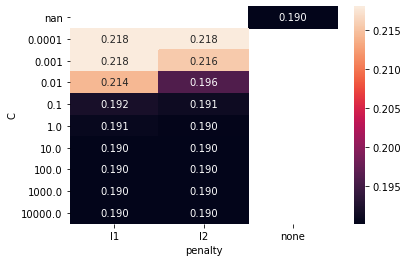

In [154]:
results12 = pd.DataFrame( best_model12.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results12['score_acc'] = 1 - best_model12.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols12 = results12.columns.to_series().str.split('__').apply(lambda x: x[-1])
results12.columns = cols12

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results12.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results12

In [252]:
#assigning result
acc_12 = ("c = 10.0, penalty = l2, solver = lbfgs, acc = 0.1900")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.218000
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.218000
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.218000
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.213474
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.211774
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.190784
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.185090
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.183180
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.182559
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.182072


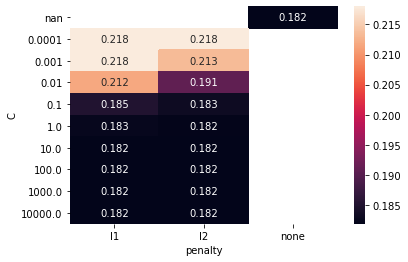

In [156]:
results12 = pd.DataFrame( best_model12.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results12['score_precision'] = 1 - best_model12.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols12 = results12.columns.to_series().str.split('__').apply(lambda x: x[-1])
results12.columns = cols12

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results12.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results12

In [251]:
#assigning result
precision_12 = ("c = 10.0, penalty = l2, solver = lbfgs, precision = 0.181720")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2180
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2180
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2180
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2156
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2142
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1960
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1920
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1912
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1908
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1904


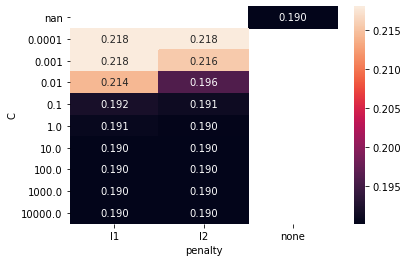

In [158]:
results12 = pd.DataFrame( best_model12.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results12['score_f1_micro'] = 1 - best_model12.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols12 = results12.columns.to_series().str.split('__').apply(lambda x: x[-1])
results12.columns = cols12

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results12.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results12

In [250]:
#assigning result
f1micro_12 = ("c = 10.0, penalty = l2, solver = lbfgs, f1_micro = 0.1900")

#### Trial 13

In [160]:
#Defining X and Y
X_credit_card = credit_card_df.iloc[:,0:-1]
Y_credit_card = credit_card_df.loc[:, "default payment next month"]
X_train, X_test, Y_train, Y_test = train_test_split( X_credit_card, Y_credit_card, train_size=5000, shuffle=True, random_state = 13)

In [161]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision','f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model13 = clf.fit(X_train, Y_train)

Wall time: 50.3 s


In [162]:
best_model13.cv_results_

{'mean_fit_time': array([0.00817814, 0.03111734, 0.0129653 , 0.03410912, 0.09096141,
        0.09026341, 0.20580964, 0.28665257, 0.6107214 , 0.58063755,
        0.8938693 , 0.76403799, 0.9951314 , 0.71019516, 0.99481235,
        0.67798061, 1.01686177, 0.84746771, 0.01515975, 0.0111702 ,
        0.02295799, 0.03087354, 0.03067861, 0.03898988, 0.0397923 ,
        0.03198538, 0.02630506, 0.06589589, 0.72446423]),
 'std_fit_time': array([0.00116288, 0.00203395, 0.0006309 , 0.00146601, 0.01329984,
        0.00841044, 0.07018464, 0.01642695, 0.0345223 , 0.08613597,
        0.09618351, 0.20418182, 0.21634405, 0.12820538, 0.20422587,
        0.12449048, 0.20965988, 0.19666327, 0.00562061, 0.00116315,
        0.00437684, 0.00314505, 0.00330463, 0.0059552 , 0.0059573 ,
        0.00627128, 0.00153659, 0.03379701, 0.15949885]),
 'mean_score_time': array([0.00358996, 0.00498619, 0.00379028, 0.00398932, 0.00378785,
        0.00578432, 0.00398498, 0.00457063, 0.00376787, 0.00337267,
        0.004188

In [163]:
best_model13.cv_results_['rank_test_accuracy']

array([26, 26, 26, 24, 23, 21, 19,  2,  1, 19,  4,  4,  4,  4,  4,  4,  4,
        4, 26, 25, 21,  2,  4, 14, 14, 14, 14, 14,  4])

In [164]:
best_model13.cv_results_['params'][ np.argmin(best_model13.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [165]:
best_model13.cv_results_['params'][ np.argmin(best_model13.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [166]:
best_model13.cv_results_['params'][ np.argmin(best_model13.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2308
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2308
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2308
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2228
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2178
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1990
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1934
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1932
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1930
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1934


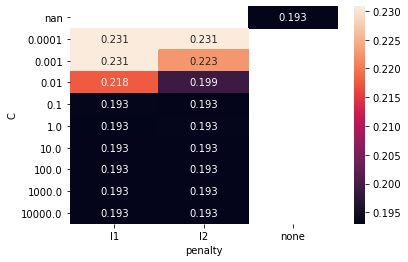

In [167]:
results13 = pd.DataFrame( best_model13.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results13['score_acc'] = 1 - best_model13.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols13 = results13.columns.to_series().str.split('__').apply(lambda x: x[-1])
results13.columns = cols13

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results13.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results13

In [254]:
#assigning result
acc_13 = ("c = 1.0, penalty = l1, solver = saga, acc = 0.1930")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.230800
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.230800
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.230800
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.220305
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.213357
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.192007
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.184905
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.183898
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.183313
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.183257


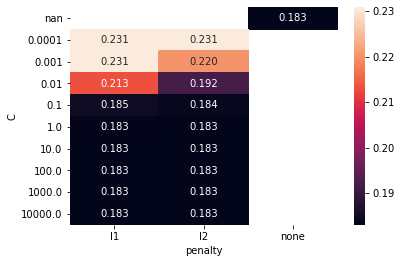

In [169]:
results13 = pd.DataFrame( best_model13.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results13['score_precision'] = 1 - best_model13.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols13 = results13.columns.to_series().str.split('__').apply(lambda x: x[-1])
results13.columns = cols13

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results13.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results13

In [255]:
#assigning result
precision_13 = ("C = 10.0, penality = l1, solver = saga, precision = 0.183077")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2308
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2308
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2308
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2228
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2178
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1990
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1934
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1932
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1930
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1934


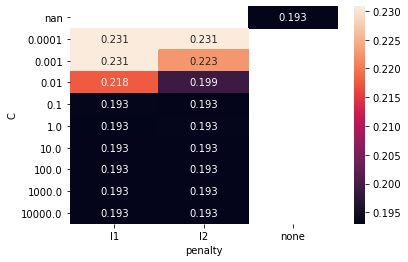

In [171]:
results13 = pd.DataFrame( best_model13.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results13['score_f1_micro'] = 1 - best_model13.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols13 = results13.columns.to_series().str.split('__').apply(lambda x: x[-1])
results13.columns = cols13

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results13.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results13

In [253]:
#assigning result
f1micro_13 = ("c = 1.0, penalty = l1, solver = saga, f1_micro = 0.1930")

#### Trial 14

In [173]:
#Defining X and Y
X_credit_card = credit_card_df.iloc[:,0:-1]
Y_credit_card = credit_card_df.loc[:, "default payment next month"]
X_train, X_test, Y_train, Y_test = train_test_split( X_credit_card, Y_credit_card, train_size=5000, shuffle=True, random_state = 14)

In [174]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision','f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model14 = clf.fit(X_train, Y_train)

Wall time: 38.5 s


In [175]:
best_model14.cv_results_

{'mean_fit_time': array([0.01116982, 0.0233376 , 0.01356378, 0.024933  , 0.03610339,
        0.0446805 , 0.13284502, 0.19910359, 0.60378542, 0.43742094,
        0.71020045, 0.53930244, 0.73802824, 0.54991064, 0.76860313,
        0.54930696, 0.80556998, 0.52340412, 0.0093749 , 0.01017284,
        0.01515937, 0.02273898, 0.02513285, 0.03590398, 0.03291254,
        0.04029198, 0.02852373, 0.05026565, 0.5427165 ]),
 'std_fit_time': array([0.00212982, 0.00162059, 0.002239  , 0.00236009, 0.00554946,
        0.00547718, 0.06001399, 0.03345381, 0.13320762, 0.08688731,
        0.18489287, 0.12141034, 0.14594947, 0.12460094, 0.15966409,
        0.10724625, 0.2066938 , 0.1060045 , 0.00048867, 0.00097733,
        0.0023091 , 0.00239333, 0.00400903, 0.01214935, 0.00378487,
        0.01535514, 0.00448685, 0.0289302 , 0.09892743]),
 'mean_score_time': array([0.01436162, 0.00997334, 0.01216722, 0.00638304, 0.00518641,
        0.00398941, 0.00339069, 0.00365615, 0.0033833 , 0.00416799,
        0.004184

In [176]:
best_model14.cv_results_['rank_test_accuracy']

array([26, 26, 26, 24, 23, 21, 18, 19,  1,  2,  2,  5,  5,  5,  5,  5,  5,
        5, 26, 24, 21, 19,  2,  5,  5,  5,  5,  5,  5])

In [177]:
best_model14.cv_results_['params'][ np.argmin(best_model14.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [178]:
best_model14.cv_results_['params'][ np.argmin(best_model14.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [179]:
best_model14.cv_results_['params'][ np.argmin(best_model14.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2152
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2152
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2152
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2082
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2068
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1922
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1846
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1852
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1836
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1840


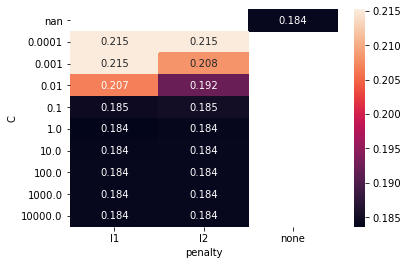

In [180]:
results14 = pd.DataFrame( best_model14.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results14['score_acc'] = 1 - best_model14.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols14 = results14.columns.to_series().str.split('__').apply(lambda x: x[-1])
results14.columns = cols14

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results14.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results14

In [257]:
#assigning result
acc_14 = ("c = 1.0, penalty = l1, solver = saga, acc = 0.1836")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.215200
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.215200
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.215200
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.207534
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.205803
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.186272
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.177213
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.176624
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.175209
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.175283


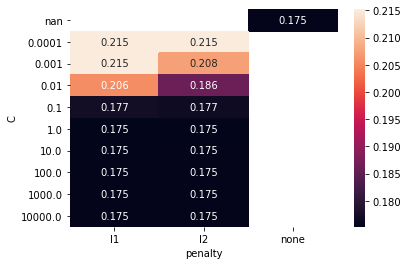

In [182]:
results14 = pd.DataFrame( best_model14.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results14['score_precision'] = 1 - best_model14.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols14 = results14.columns.to_series().str.split('__').apply(lambda x: x[-1])
results14.columns = cols14

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results14.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results14

In [258]:
#assigning result
precision_14 = ("c = 1.0, penalty = l1, solver = saga, precision = 0.175209")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2152
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2152
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2152
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2082
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2068
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1922
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1846
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1852
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1836
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1840


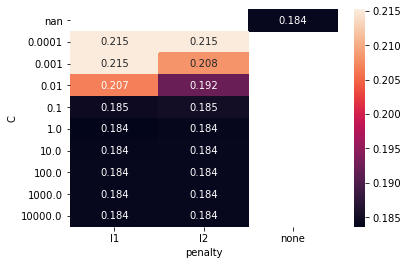

In [184]:
results14 = pd.DataFrame( best_model14.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results14['score_f1_micro'] = 1 - best_model14.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols14 = results14.columns.to_series().str.split('__').apply(lambda x: x[-1])
results14.columns = cols14

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results14.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results14

In [256]:
#assigning result
f1micro_14 = ("c = 1.0, penalty = l1, solver = saga, f1_micro = 0.1836")

#### Trial 15

In [186]:
#Defining X and Y
X_credit_card = credit_card_df.iloc[:,0:-1]
Y_credit_card = credit_card_df.loc[:, "default payment next month"]
X_train, X_test, Y_train, Y_test = train_test_split( X_credit_card, Y_credit_card, train_size=5000, shuffle=True, random_state = 15)

In [187]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision','f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model15 = clf.fit(X_train, Y_train)

Wall time: 53.3 s


In [188]:
best_model15.cv_results_

{'mean_fit_time': array([0.00738029, 0.03780012, 0.01515937, 0.0484704 , 0.10262175,
        0.07873611, 0.42694411, 0.31868453, 0.91563206, 0.67634254,
        0.96691756, 0.70049028, 1.02209063, 0.72748919, 0.99444528,
        0.73537145, 1.02742796, 0.67006378, 0.0101728 , 0.01117043,
        0.01476064, 0.03371468, 0.03577108, 0.03017797, 0.03979692,
        0.04268575, 0.06620188, 0.0472033 , 0.6942163 ]),
 'std_fit_time': array([0.0010171 , 0.01086237, 0.00358999, 0.01651624, 0.01256191,
        0.00443128, 0.03171035, 0.03651904, 0.14723256, 0.13515648,
        0.16148894, 0.11626651, 0.13717934, 0.14232265, 0.16982165,
        0.15188808, 0.21622348, 0.1097142 , 0.00116292, 0.00171584,
        0.00230895, 0.02058644, 0.01514096, 0.00256122, 0.01052143,
        0.0068931 , 0.03752718, 0.01602199, 0.12719301]),
 'mean_score_time': array([0.0038909 , 0.00837812, 0.01136975, 0.00578403, 0.00659127,
        0.00319796, 0.00357432, 0.003579  , 0.00398946, 0.00468907,
        0.003191

In [189]:
best_model15.cv_results_['rank_test_accuracy']

array([26, 26, 26, 24, 23, 21,  2, 19,  1, 17, 16,  2,  2,  2,  2,  2,  2,
        2, 26, 24, 21, 19, 17,  2,  2,  2,  2,  2,  2])

In [190]:
best_model15.cv_results_['params'][ np.argmin(best_model15.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [191]:
best_model15.cv_results_['params'][ np.argmin(best_model15.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [192]:
best_model15.cv_results_['params'][ np.argmin(best_model15.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2216
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2216
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2216
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2154
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2148
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1956
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1924
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1930
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1922
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1928


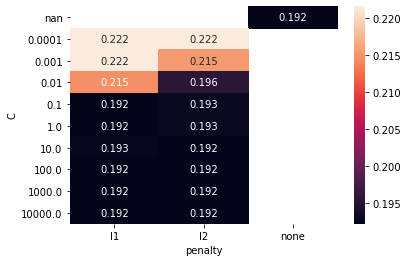

In [193]:
results15 = pd.DataFrame( best_model15.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results15['score_acc'] = 1 - best_model15.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols15 = results15.columns.to_series().str.split('__').apply(lambda x: x[-1])
results15.columns = cols15

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results15.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results15

In [260]:
#assigning result
acc_15 = ("c = 1.0, penalty = l1, solver = saga, acc = 0.1922")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.221600
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.221600
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.221600
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.214777
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.213958
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.190631
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.183672
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.183811
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.182682
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.182390


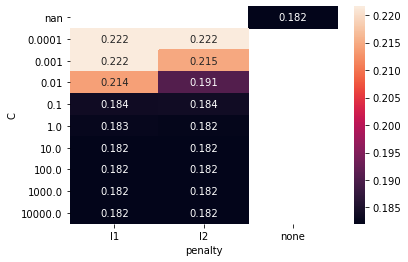

In [195]:
results15 = pd.DataFrame( best_model15.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results15['score_precision'] = 1 - best_model15.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols15 = results15.columns.to_series().str.split('__').apply(lambda x: x[-1])
results15.columns = cols15

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results15.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results15

In [261]:
#assigning result
precision_15 = ("C = 10.0, penality = l2, solver = saga, precision = 0.182033")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.2216
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2216
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.2216
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.2154
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.2148
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.1956
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.1924
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.1930
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.1922
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.1928


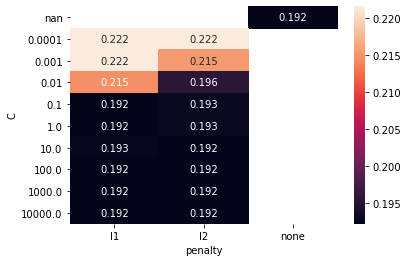

In [197]:
results15 = pd.DataFrame( best_model15.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results15['score_f1_micro'] = 1 - best_model15.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols15 = results15.columns.to_series().str.split('__').apply(lambda x: x[-1])
results15.columns = cols15

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results15.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results15

In [259]:
#assigning result
f1micro_15 = ("c = 1.0, penalty = l1, solver = saga, f1_micro = 0.1922")

## Training Results

In [265]:
#adding results into a list
acc_List = [acc_1,acc_2,acc_3,acc_4,acc_5,acc_6,acc_7,acc_8,acc_9,acc_10,acc_11,acc_12,acc_13,acc_14,acc_15]
precision_List = [precision_1,precision_2,precision_3,precision_4,precision_5,precision_6,precision_7,precision_8,precision_9,precision_10,precision_11,precision_12,precision_13,precision_14,precision_15]
f1micro_List = [f1micro_1,f1micro_2,f1micro_3,f1micro_4,f1micro_5,f1micro_6,f1micro_7,f1micro_8,f1micro_9,f1micro_10,f1micro_11,f1micro_12,f1micro_13,f1micro_14,f1micro_15]

In [266]:
#creating dataframe of results
data = {'Acc': acc_List, 'Precision': precision_List, 'F1_micro':f1micro_List}

In [267]:
trainingResults  = pd.DataFrame(data = data)
pd.options.display.max_colwidth = 100
trainingResults

,Acc,Precision,F1_micro
0,"c = 0.1, penalty = l2, solver = saga, acc = 0.1772","C = 1.0, penality = l2, solver = saga, precision = 0.168211","c = 0.1, penalty = l2, solver = saga, f1_micro = 0.1772"
1,"c = 1.0, penalty = l1, solver = saga, acc = 0.1918","C = 1.0, penality = l1, solver = saga, precision = 0.183173","c = 1.0, penalty = l1, solver = saga, f1_micro = 0.1918"
2,"c = 100, penalty = l2, solver = lbfgs, acc = 0.1878","C = 1.0, penality = l1, solver = saga, precision = 0.125419","c = 100, penalty = l2, solver = lbfgs, f1_micro = 0.1878"
3,"c = 1.0, penalty = l2, solver = saga, acc = 0.1884","c = 1.0, penalty = l2, solver = saga, precision = 0.176898","c = 1.0, penalty = l2, solver = saga, f1_micro = 0.1884"
4,"c = 10, penalty = l2, solver = saga, acc = 0.1786","c = 10, penalty = l2, solver = saga, precision = 0.170645","c = 10, penalty = l2, solver = saga, f1_micro = 0.1786"
5,"c = 100, penalty = l1, solver = saga, acc = 0.1916","c = 100, penalty = l1, solver = saga, precision = 0.184219","c = 100, penalty = l1, solver = saga, f1_micro = 0.1916"
6,"c = 0.1, penalty = l2, solver = saga, acc = 0.1978","C = 10, penality = l1, solver = saga, precision = 0.188138","c = 0.1, penalty = l2, solver = saga, f1_micro = 0.1978"
7,"c = 0.1, penalty = l2, solver = saga, acc = 0.1930","c = 1.0, penalty = l2, solver = lbfgs, precision = 0.185221","c = 0.1, penalty = l2, solver = saga, f1_micro = 0.1930"
8,"c = 10.0, penalty = l1, solver = saga, acc = 0.1868","c = 10.0, penalty = l1, solver = saga, precision = 0.175835","c = 10.0, penalty = l1, solver = saga, f1_micro = 0.1868"
9,"c = 0.1, penalty = l2, solver = saga, acc = 0.1882","c = 1.0, penalty = l1, solver = saga, precision = 0.180648","c = 0.1, penalty = l2, solver = saga, f1_micro = 0.1882"


## Testing Dataset

In [202]:
#Defining X and Y
X_credit_card = credit_card_df.iloc[:,0:-1]
Y_credit_card = credit_card_df.loc[:, "default payment next month"]
X_train, X_test, Y_train, Y_test = train_test_split( X_credit_card, Y_credit_card, train_size=5000, shuffle=True, random_state = 16)

In [203]:
%%time
# Create a pipeline - RF is a stand in, we will populate the classifier part below
pipe = Pipeline([('std', StandardScaler()),
                 ('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5),
                   scoring=['accuracy', 'precision','f1_micro'], refit=False,
                   verbose=0)

# Fit grid search
best_model16 = clf.fit(X_test, Y_test)

Wall time: 2min 52s


In [204]:
best_model16.cv_results_

{'mean_fit_time': array([0.04338512, 0.1340415 , 0.23128614, 0.19807062, 0.37095513,
        0.81534185, 1.67557445, 1.70004559, 2.60444617, 2.16815462,
        2.84930549, 2.3014286 , 3.21810327, 2.32602539, 3.02747149,
        2.18722882, 3.0712564 , 2.16078792, 0.03849683, 0.04408212,
        0.06343026, 0.08098345, 0.09554462, 0.08897324, 0.08553543,
        0.09335756, 0.11289778, 0.10800905, 2.36957889]),
 'std_fit_time': array([0.0121475 , 0.04632017, 0.04666693, 0.02152564, 0.05899744,
        0.12584706, 0.33278647, 0.28932522, 0.71978558, 0.53015735,
        0.62811489, 0.59300338, 0.79225451, 0.60655672, 0.66131161,
        0.59435527, 0.60221292, 0.44297366, 0.00638933, 0.00277815,
        0.00953679, 0.0201393 , 0.02370538, 0.02014144, 0.00860608,
        0.02666458, 0.03536406, 0.02140991, 0.56424327]),
 'mean_score_time': array([0.00698137, 0.00658274, 0.00638285, 0.00638266, 0.00618362,
        0.0054915 , 0.00597773, 0.00598388, 0.00617728, 0.00637836,
        0.006299

In [205]:
best_model16.cv_results_['rank_test_accuracy']

array([29, 27, 26, 24, 23, 21, 20, 19,  1,  2,  2,  2,  2,  2,  2,  2,  2,
        2, 27, 24, 21, 18, 12, 12, 12, 12, 12, 12,  2])

In [206]:
best_model16.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [207]:
best_model16.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_precision'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [208]:
best_model16.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.22280
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.21992
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.21936
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.20064
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.19344
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.19144
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.19068
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.19048
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.19028
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.19032


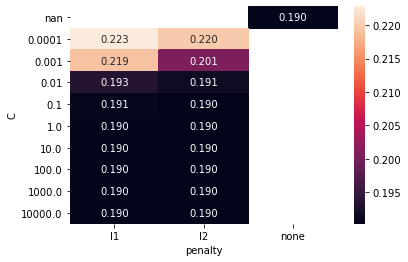

In [209]:
results16 = pd.DataFrame( best_model16.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results16['score_acc'] = 1 - best_model16.cv_results_['mean_test_accuracy']

# get rid of classifierXX in columns
cols16 = results16.columns.to_series().str.split('__').apply(lambda x: x[-1])
results16.columns = cols16

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results16.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results16

In [263]:
#assigning result
acc_16 = ("c = 0.1, penalty = l2, solver = saga, acc = 0.19048")

,classifier,C,penalty,solver,score_precision
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.222800
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.219316
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.218389
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.195728
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.187517
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.184341
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.182988
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.182564
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.182359
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.182367


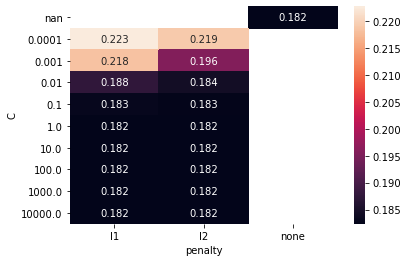

In [211]:
results16 = pd.DataFrame( best_model16.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results16['score_precision'] = 1 - best_model16.cv_results_['mean_test_precision']

# get rid of classifierXX in columns
cols16 = results16.columns.to_series().str.split('__').apply(lambda x: x[-1])
results16.columns = cols16

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results16.query('solver=="saga"').pivot('C','penalty','score_precision'),
             annot=True, fmt='.3f')

results16

In [264]:
#assigning result
precision_16 = ("C = 1.0, penality = l2, solver = saga, precision = 0.182367")

,classifier,C,penalty,solver,score_f1_micro
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.22280
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.21992
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.21936
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.20064
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.19344
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.19144
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.19068
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.19048
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.19028
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.19032


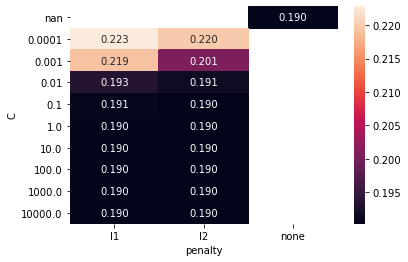

In [213]:
results16 = pd.DataFrame( best_model16.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results16['score_f1_micro'] = 1 - best_model16.cv_results_['mean_test_f1_micro']

# get rid of classifierXX in columns
cols16 = results16.columns.to_series().str.split('__').apply(lambda x: x[-1])
results16.columns = cols16

# lets show the results for the saga solver across penalty & C values
sns.heatmap( results16.query('solver=="saga"').pivot('C','penalty','score_f1_micro'),
             annot=True, fmt='.3f')

results16

In [262]:
#assigning result
f1micro_16 = ("c = 0.1, penalty = l2, solver = saga, f1_micro = 0.19048")

## Testing Results

In [268]:
#defining results
test_acc = [acc_16]
test_precision = [precision_16]
test_f1micro = [f1micro_16]

In [269]:
#adding result to a dataframe
data = {'Acc': test_acc, 'Precision': test_precision, 'F1_micro': test_f1micro}

In [270]:
trainingResults  = pd.DataFrame(data = data)
pd.options.display.max_colwidth = 100
trainingResults

,Acc,Precision,F1_micro
0,"c = 0.1, penalty = l2, solver = saga, acc = 0.19048","C = 1.0, penality = l2, solver = saga, precision = 0.182367","c = 0.1, penalty = l2, solver = saga, f1_micro = 0.19048"
